# Data analysis: Velib

Author: O. Roustant, INSA Toulouse. February 2022.


We consider the ‘Vélib’ data set, related to the bike sharing system of Paris. The data are loading profiles of the bike stations over one week, collected every hour, from the period Monday 2nd Sept. - Sunday 7th Sept., 2014. The loading profile of a station, or simply loading, is defined as the ratio of number of available bikes divided by the number of bike docks. A loading of 1 means that the station is fully loaded, i.e. all bikes are available. A loading of 0 means that the station is empty, all bikes have been rent.

From the viewpoint of data analysis, the individuals are the stations. The variables are the 168 time steps (hours in the week). The aim is to detect clusters in the data, corresponding to common customer usages. This clustering should then be used to predict the loading profile.

In [1]:
rm(list = ls())   # erase everything, start from scratch!

# load the data from package funFEM

library("funFEM")
data(velib)
help("velib")
#str(velib)

Loading required package: MASS

Loading required package: fda

Loading required package: splines

Loading required package: Matrix

Loading required package: fds

Loading required package: rainbow

Loading required package: pcaPP

Loading required package: RCurl

Loading required package: deSolve


Attaching package: ‘fda’


The following object is masked from ‘package:graphics’:

    matplot


Loading required package: elasticnet

Loading required package: lars

Loaded lars 1.2




velib                  package:funFEM                  R Documentation

_T_h_e _V_é_l_i_b _d_a_t_a _s_e_t

_D_e_s_c_r_i_p_t_i_o_n:

     This data set contains data from the bike sharing system of Paris,
     called Vélib. The data are loading profiles of the bike stations
     over one week. The data were collected every hour during the
     period Sunday 1st Sept. - Sunday 7th Sept., 2014.

_U_s_a_g_e:

     data(velib)
     
_F_o_r_m_a_t:

     The format is:

     - data: the loading profiles (nb of available bikes / nb of bike
     docks) of the 1189 stations at 181 time points.

     - position: the longitude and latitude of the 1189 bike stations.

     - dates: the download dates.

     - bonus: indicates if the station is on a hill (bonus = 1).

     - names: the names of the stations.

_S_o_u_r_c_e:

     The real time data are available at
     https://developer.jcdecaux.com/ (with an api key).

_R_e_f_e_r_e_n_c_e_s:

    

In [2]:
# data preparation
x <- as.matrix(velib$data)
colnames(x) <- 1:ncol(x)
rownames(x) <- velib$names


# select exactly 7 days of data (we remove the first 13 dates)
dates <- 14:181
x <- x[, dates]
colnames(x) <- 1:length(dates)
head(x)

,1,2,3,4,5,6,7,8,9,10,⋯,159,160,161,162,163,164,165,166,167,168
EURYALE DEHAYNIN,0.03846154,0.03846154,0.07692308,0.03846154,0.03846154,0.03846154,0.03846154,0.03846154,0.10714286,0.00000000,⋯,0.29629630,0.11111111,0.1111111,0.14814815,0.30769231,0.07692308,0.11538462,0.07692308,0.1538462,0.1538462
LEMERCIER,0.47826087,0.47826087,0.47826087,0.43478261,0.43478261,0.43478261,0.43478261,0.43478261,0.26086957,0.04347826,⋯,0.04347826,0.00000000,0.2173913,0.13043478,0.04545455,0.17391304,0.17391304,0.17391304,0.2608696,0.3913043
MEZIERES RENNES,0.21818182,0.14545455,0.12727273,0.10909091,0.10909091,0.10909091,0.09090909,0.09090909,0.05454545,0.10909091,⋯,0.25925926,0.25925926,0.2037037,0.12962963,0.14814815,0.29629630,0.31481481,0.37037037,0.3703704,0.4074074
FARMAN,0.95238095,0.95238095,0.95238095,0.95238095,0.95238095,0.95238095,0.95238095,1.00000000,1.00000000,1.00000000,⋯,1.00000000,1.00000000,0.9047619,0.85714286,0.85714286,0.85714286,0.76190476,0.76190476,0.7619048,0.7619048
QUAI DE LA RAPEE,0.92753623,0.81159420,0.73913043,0.72463768,0.72463768,0.72463768,0.72463768,0.72463768,0.75362319,0.97101449,⋯,0.22727273,0.45454545,0.5909091,0.83333333,1.00000000,0.81818182,0.63636364,0.71212121,0.6212121,0.5757576
CHOISY POINT D'IVRY,0.16666667,0.16666667,0.16666667,0.16666667,0.16666667,0.16666667,0.16666667,0.16666667,0.08333333,0.00000000,⋯,0.34782609,0.08695652,0.1153846,0.08695652,0.13043478,0.08695652,0.08695652,0.43478261,0.3913043,0.5217391


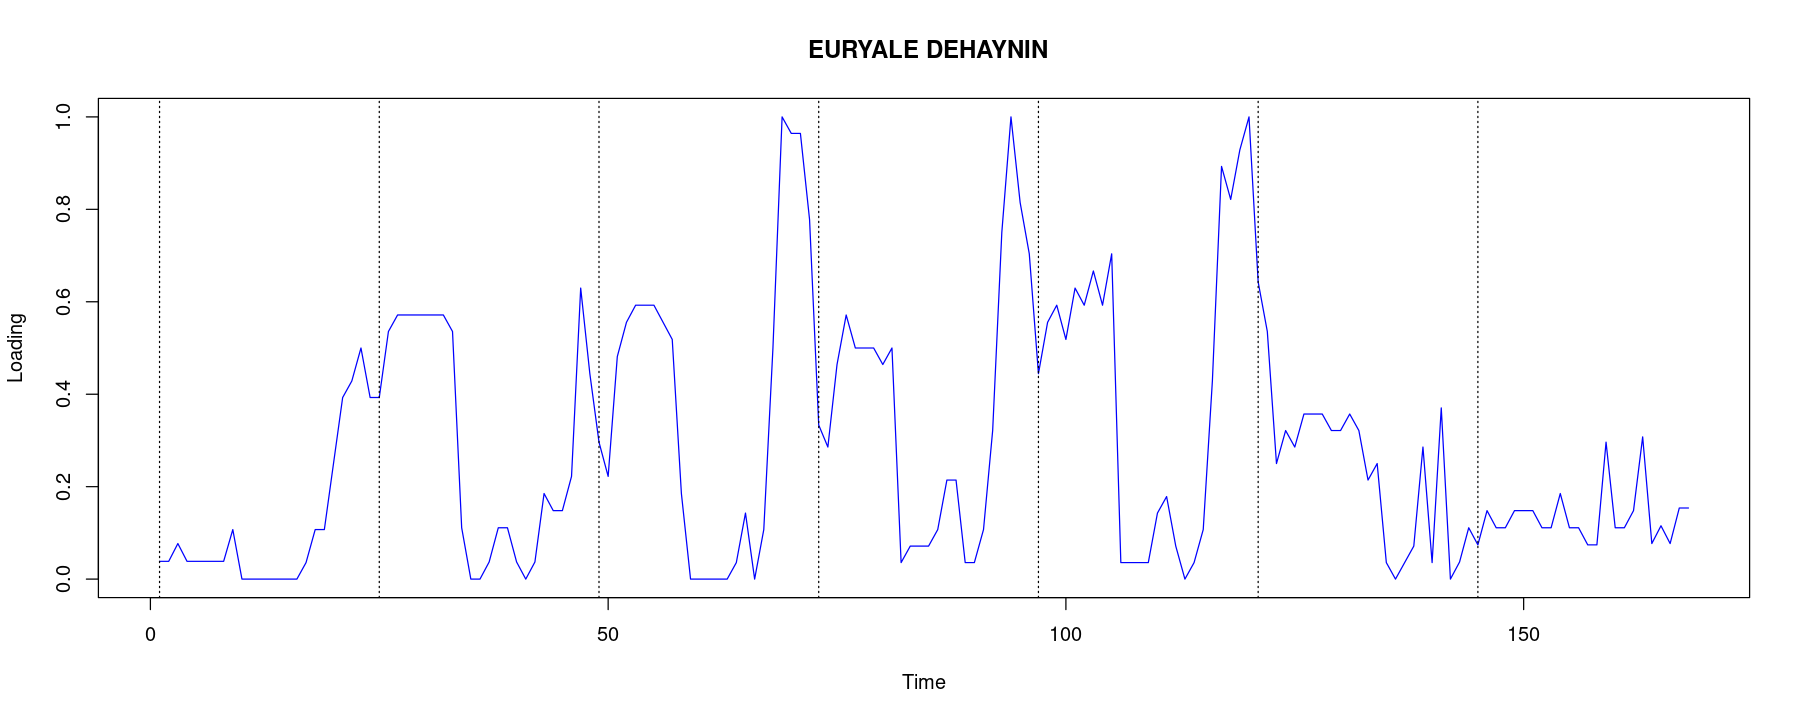

In [3]:
timeTick <- 1 + 24*(0:6)  # vector corresponding to the beginning of days
par(mfrow = c(1, 1))
options(repr.plot.width = 15, repr.plot.height = 6)

plot(x[1, ], col = "blue", type = "l", ylim = c(0, 1), 
     xlab = "Time", ylab = "Loading", main = rownames(x)[1])
abline(v = timeTick, lty = "dotted")


In [4]:
# From now on, we use numbers instead of station names, 
# in order to simplify printing
rownames(x) <- 1:nrow(x)

# Descriptive statistics.

Some ideas : 

1. Draw a matrix of plots of size 4*4, corresponding to the first 16 stations. (Do not forget the vertical lines corresponding to days).
2. Draw the boxplot of the variables, sorted in time order. 
What can you say about the distribution of the variables? 
Position, dispersion, symmetry?
3. Plot the average hourly loading for each day (on a single graph).
4. Plot the stations coordinates on a 2D map (latitude versus longitude). Use the package ggmap (function 'qmplot') to visualize the average loading for a given hour (6h, 12h, 23h) as a color scale.
Comments ?
5. Use a different color for stations which are located on a hill. (Use the basis 'plot' function, and the function 'qmplot' of R package ggmap).
6. Redo questions 1-3 for the subset of stations which are located on a hill. Same questions for those who are not. Comment?

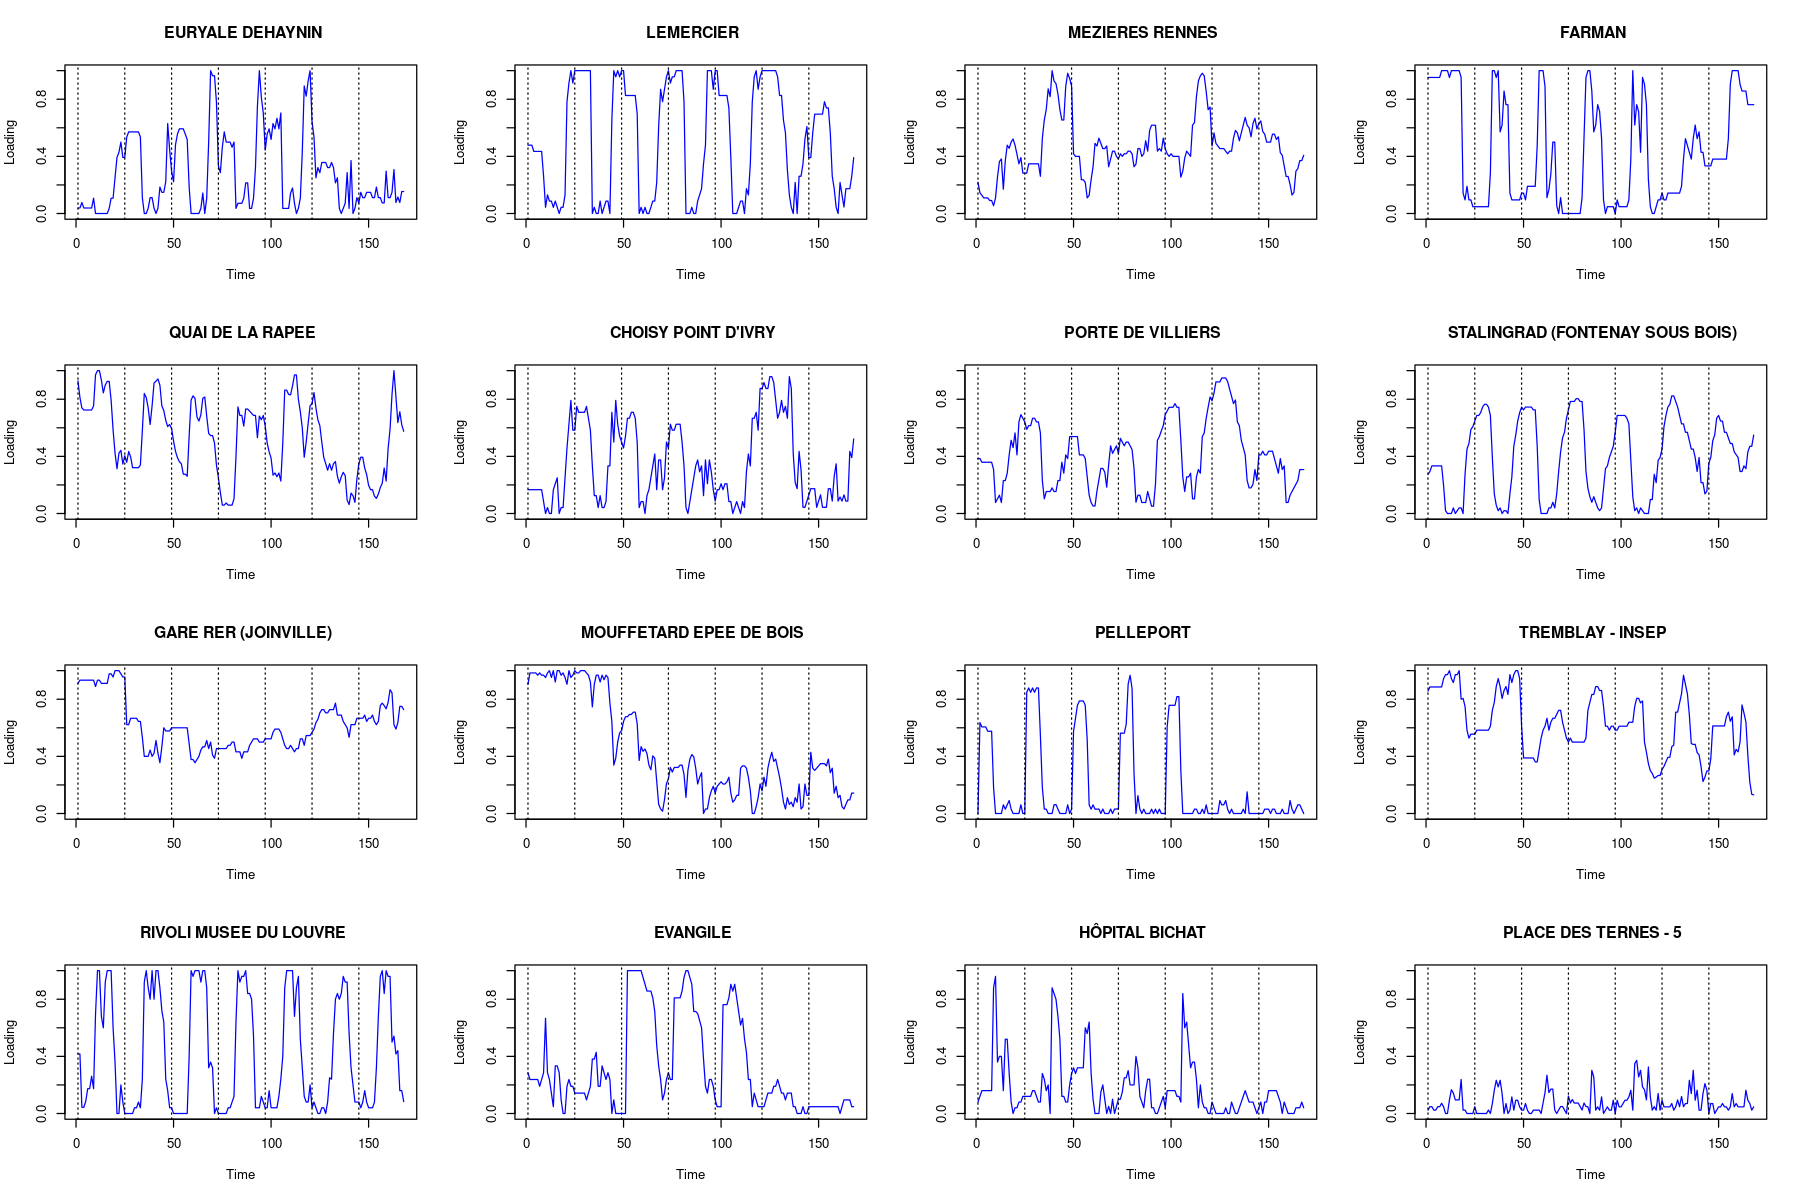

In [5]:
# Q1
par(mfrow = c(4, 4))
options(repr.plot.width = 15, repr.plot.height = 10)

for (i in 1:16){
    plot(x[i, ], col = "blue", type = "l", ylim = c(0, 1), 
         xlab = "Time", ylab = "Loading", main = velib$names[i])
    abline(v = timeTick, lty = "dotted")
}


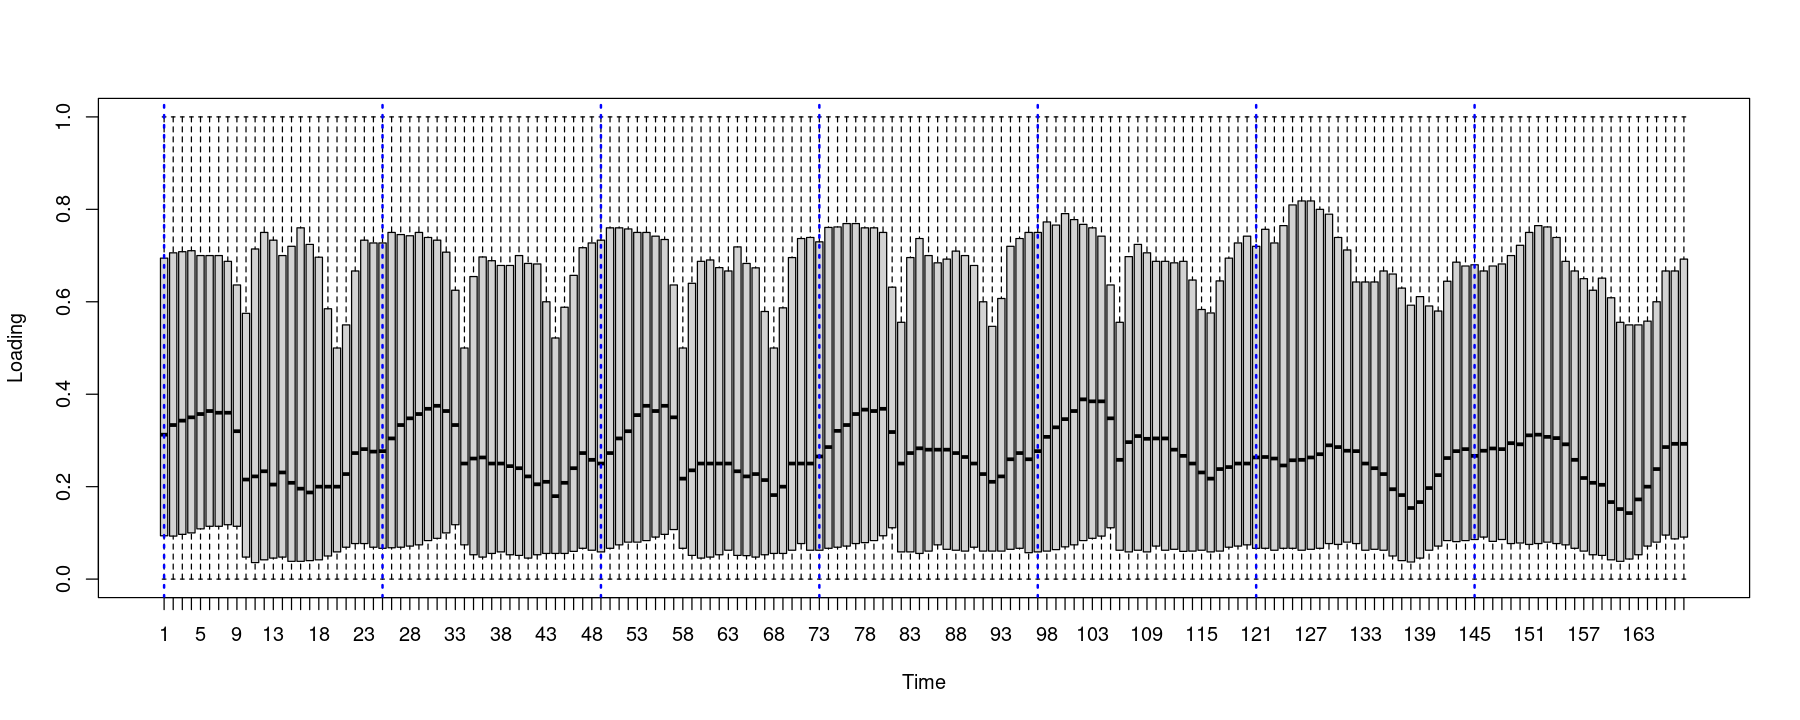

boxplot                package:graphics                R Documentation

_B_o_x _P_l_o_t_s

_D_e_s_c_r_i_p_t_i_o_n:

     Produce box-and-whisker plot(s) of the given (grouped) values.

_U_s_a_g_e:

     boxplot(x, ...)
     
     ## S3 method for class 'formula'
     boxplot(formula, data = NULL, ..., subset, na.action = NULL,
             xlab = mklab(y_var = horizontal),
             ylab = mklab(y_var =!horizontal),
             add = FALSE, ann = !add, horizontal = FALSE,
             drop = FALSE, sep = ".", lex.order = FALSE)
     
     ## Default S3 method:
     boxplot(x, ..., range = 1.5, width = NULL, varwidth = FALSE,
             notch = FALSE, outline = TRUE, names, plot = TRUE,
             border = par("fg"), col = "lightgray", log = "",
             pars = list(boxwex = 0.8, staplewex = 0.5, outwex = 0.5),
              ann = !add, horizontal = FALSE, add = FALSE, at = NULL)
     
_A_r_g_u_m_e_n_t_s:

 formula: a formula, such as ‘y ~ gr

In [6]:
# Q2
options(repr.plot.width = 15, repr.plot.height = 6)
stats <- boxplot(x, xlab = "Time", ylab = "Loading")
help(boxplot)
abline(v = timeTick, lty = "dotted", col = "blue", lwd = 2)

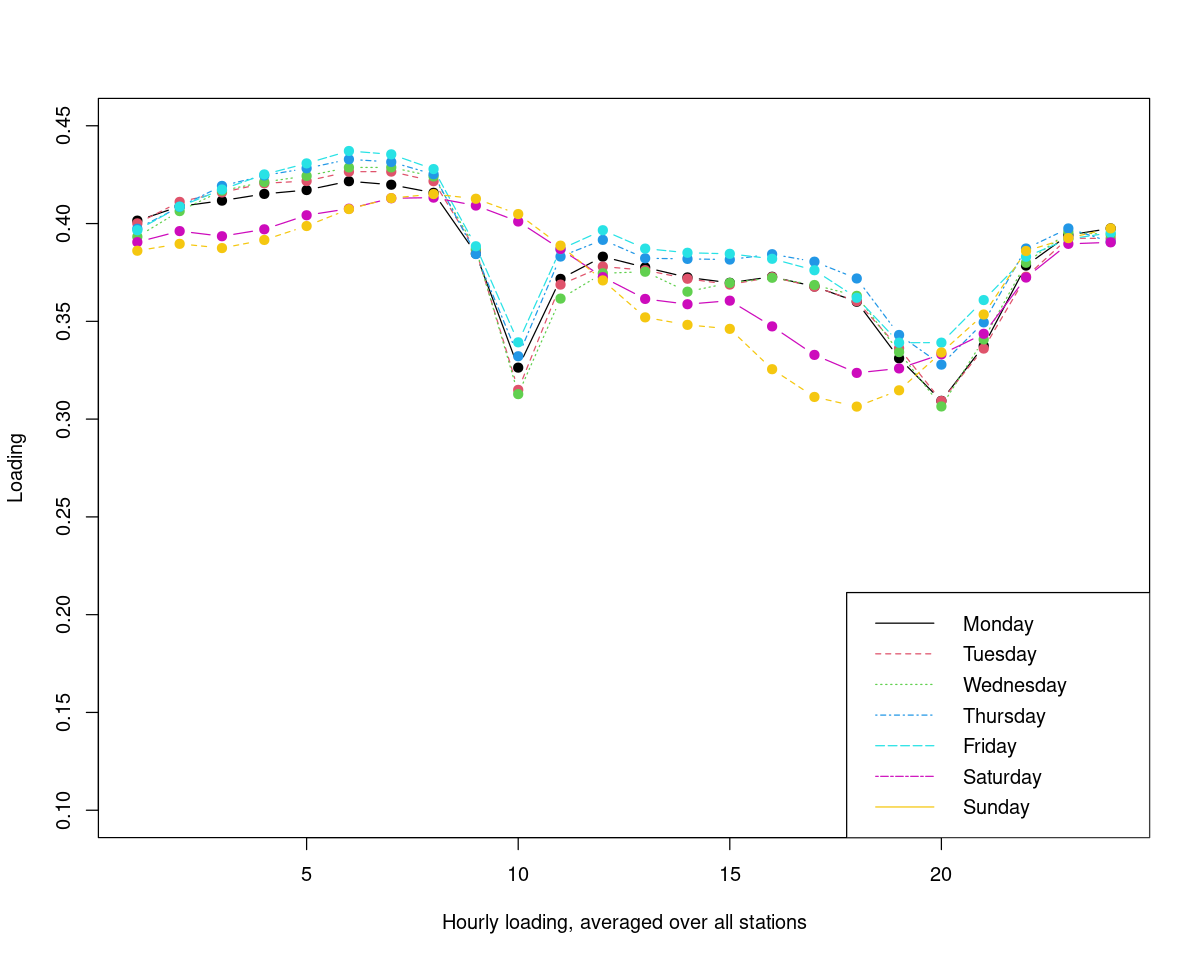

In [7]:
# Q3
xHour <- colMeans(x)
# alternatively, one can use the median returned by boxplot
# xHour <- stats$stats[3, ]
xHour <- matrix(xHour, nrow = 24)  # rearranged in columns (column 1 contains the stations 1, 2, ..., 24) 

options(repr.plot.width = 10, repr.plot.height = 8)
dayText <- c("Mon", "Tues", "Wednes", "Thurs", "Fri", "Satur", "Sun")
dayText <- paste(dayText, "day", sep = "")
matplot(xHour, type = "b", ylim = c(0.1, 0.45), col = 1:7, pch = 19, 
        xlab = "Hourly loading, averaged over all stations", ylab = "Loading")
legend("bottomright", dayText, lty = 1:7, col = 1:7)

In [8]:
str(velib)

List of 5
 $ data    :'data.frame':	1189 obs. of  181 variables:
  ..$ V1  : num [1:1189] 0.0769 0.0435 0.1091 0.5714 1 ...
  ..$ V2  : num [1:1189] 0.269 0 0.127 0.524 0.942 ...
  ..$ V3  : num [1:1189] 0.385 0.13 0.127 0.667 1 ...
  ..$ V4  : num [1:1189] 0.231 0.087 0.182 0.714 0.986 ...
  ..$ V5  : num [1:1189] 0.154 0.174 0.145 0.81 1 ...
  ..$ V6  : num [1:1189] 0.154 0.087 0.109 1 1 ...
  ..$ V7  : num [1:1189] 0.2692 0.0435 0.2545 1 1 ...
  ..$ V8  : num [1:1189] 0.08 0.0435 0.2545 0.9524 1 ...
  ..$ V9  : num [1:1189] 0.115 0.217 0.255 0.952 0.971 ...
  ..$ V10 : num [1:1189] 0.115 0.304 0.327 0.952 0.957 ...
  ..$ V11 : num [1:1189] 0.115 0.304 0.241 0.952 0.913 ...
  ..$ V12 : num [1:1189] 0.231 0.435 0.218 0.952 0.913 ...
  ..$ V13 : num [1:1189] 0.0385 0.5217 0.2182 0.9524 0.8551 ...
  ..$ V14 : num [1:1189] 0.0385 0.4783 0.2182 0.9524 0.9275 ...
  ..$ V15 : num [1:1189] 0.0385 0.4783 0.1455 0.9524 0.8116 ...
  ..$ V16 : num [1:1189] 0.0769 0.4783 0.1273 0.9524 0.7391 ...


Loading required package: ggplot2

Google's Terms of Service: https://cloud.google.com/maps-platform/terms/.

Please cite ggmap if you use it! See citation("ggmap") for details.

Using zoom = 12...

Source : http://tile.stamen.com/terrain/12/2073/1408.png

Source : http://tile.stamen.com/terrain/12/2074/1408.png

Source : http://tile.stamen.com/terrain/12/2075/1408.png

Source : http://tile.stamen.com/terrain/12/2076/1408.png

Source : http://tile.stamen.com/terrain/12/2073/1409.png

Source : http://tile.stamen.com/terrain/12/2074/1409.png

Source : http://tile.stamen.com/terrain/12/2075/1409.png

Source : http://tile.stamen.com/terrain/12/2076/1409.png

Source : http://tile.stamen.com/terrain/12/2073/1410.png

Source : http://tile.stamen.com/terrain/12/2074/1410.png

Source : http://tile.stamen.com/terrain/12/2075/1410.png

Source : http://tile.stamen.com/terrain/12/2076/1410.png



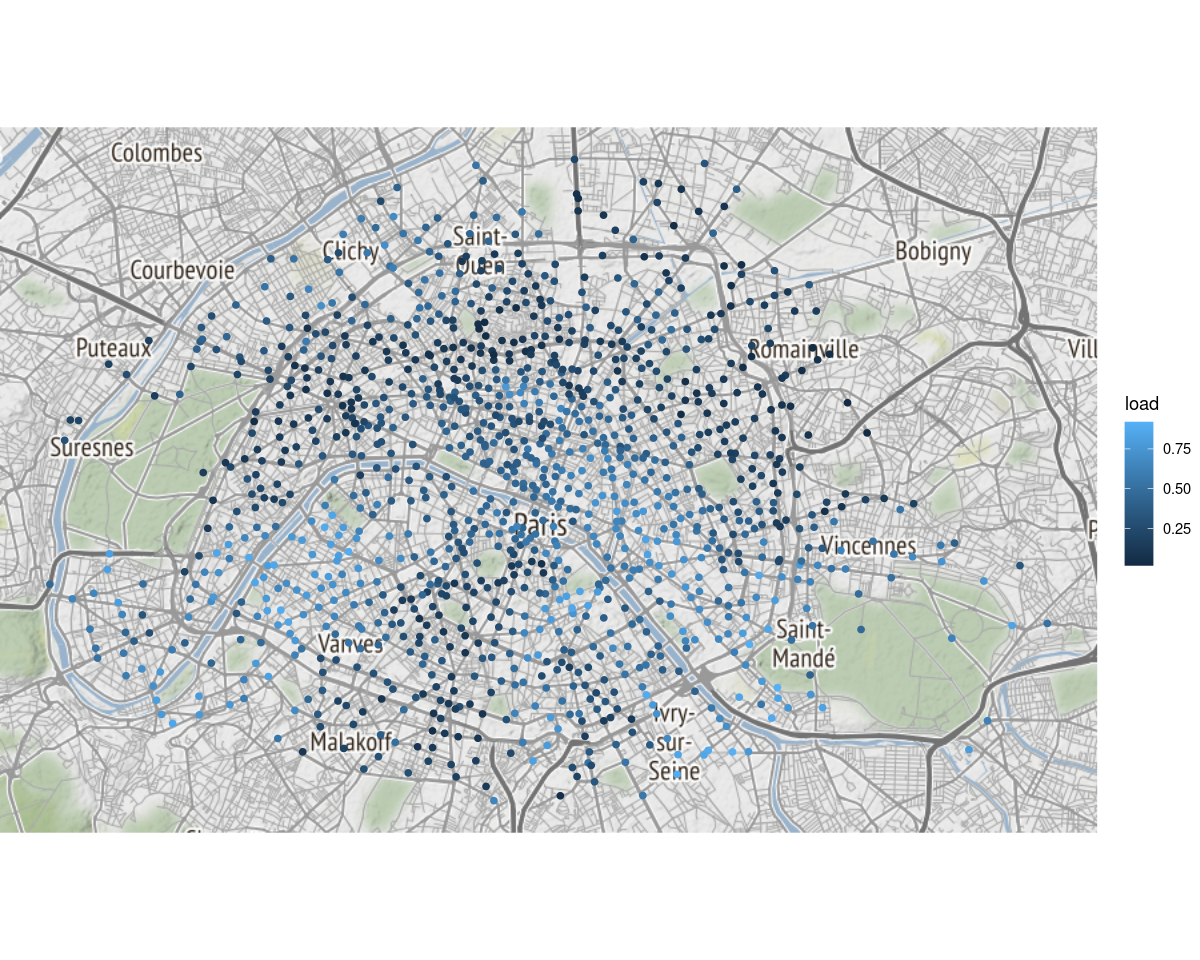

In [9]:
# Q4
library(ggmap)
# Average loading for each station
load <- rowMeans(x)  
qmplot(longitude, latitude, data = velib$position, color = load)
# Average loading at 6h, 12h et 23h (the first time step is 0h)

load6 <- rowMeans(x[, seq(from = 6, by = 24, length = 7)])
load12 <- rowMeans(x[, seq(from = 13, by = 24, length = 7)])
load23 <- rowMeans(x[, seq(from = 24, by = 24, length = 7)])
# decommenter les lignes ci-dessous pour execution
# qmplot(longitude, latitude, data = velib$position, color = load6)
# qmplot(longitude, latitude, data = velib$position, color = load12)
# qmplot(longitude, latitude, data = velib$position, color = load23)


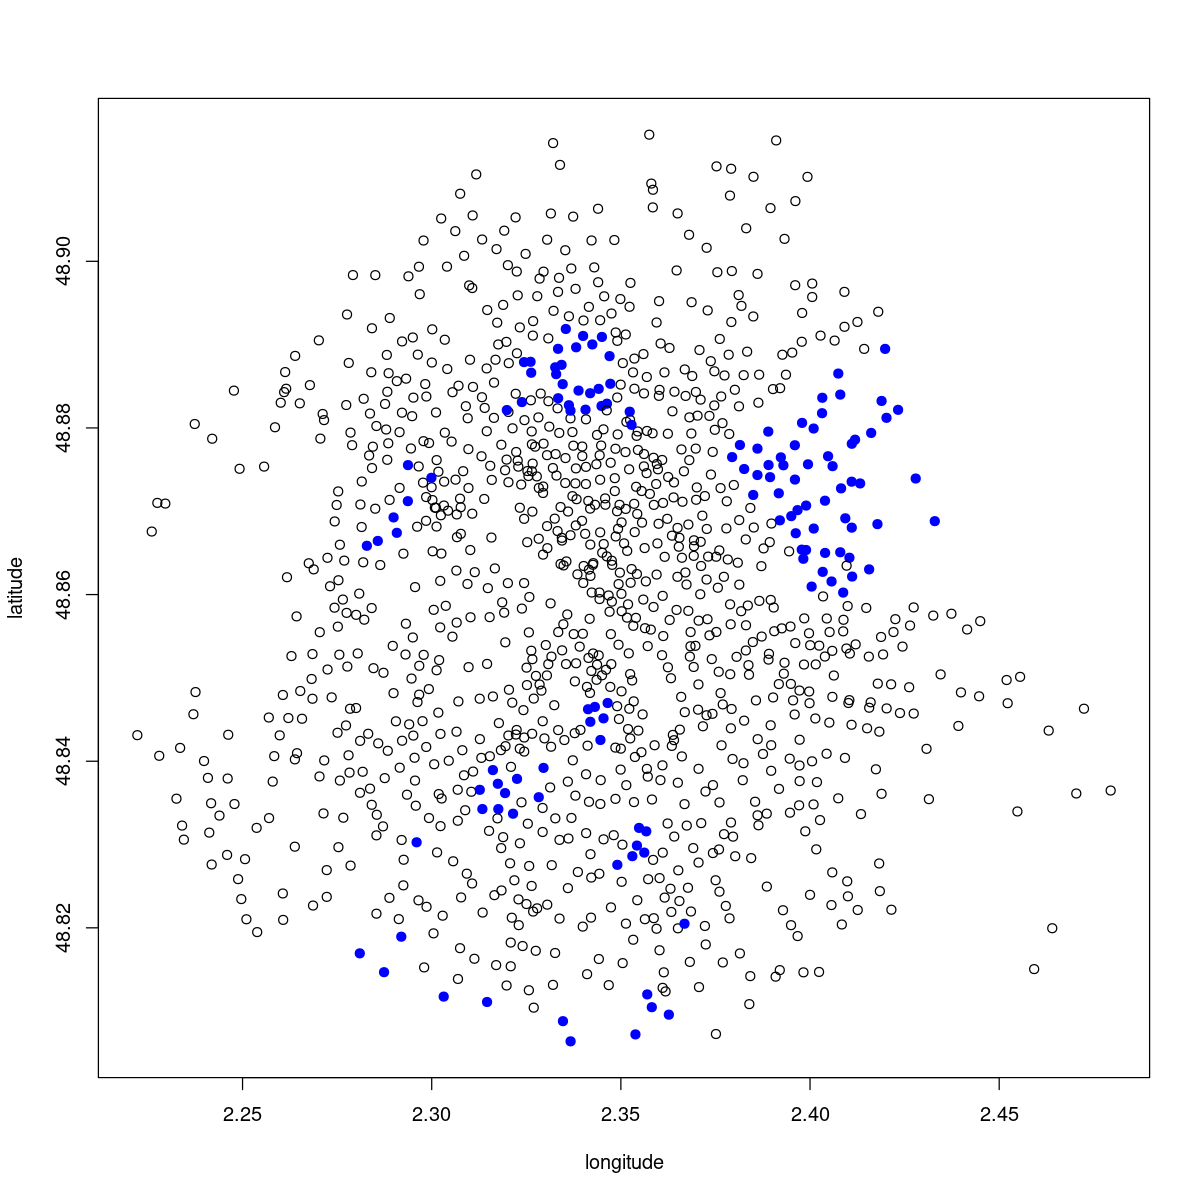

In [10]:
# Q5
options(repr.plot.width = 10, repr.plot.height = 10)
plot(velib$position, col = ifelse(velib$bonus, "blue", "black"), 
     pch = ifelse(velib$bonus, 19, 1))
# With ggmap
# Decommenter pour executer
# qmplot(longitude, latitude, data = velib$position, color = velib$bonus)

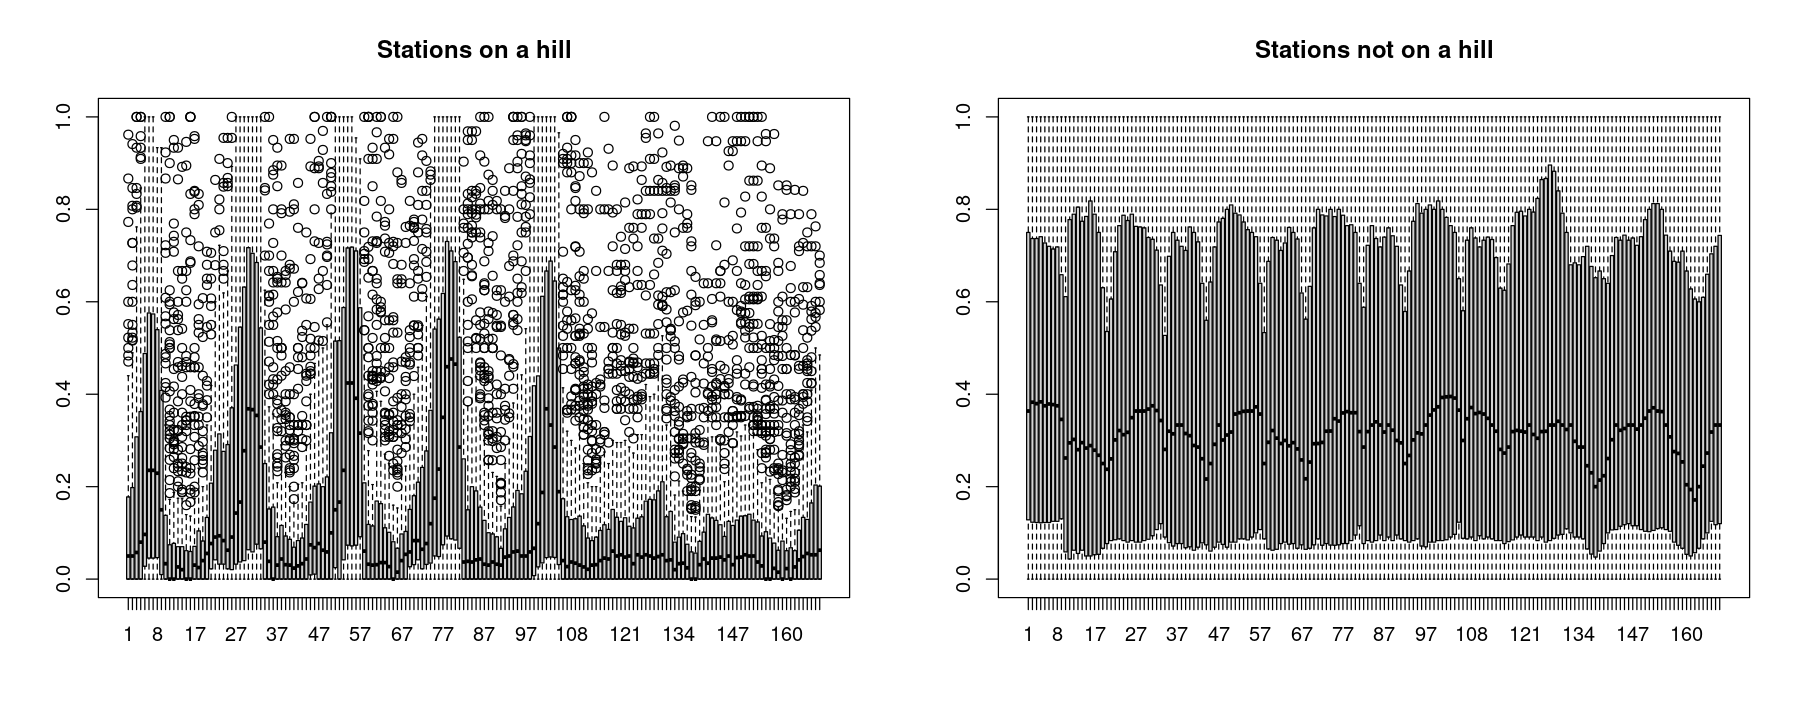

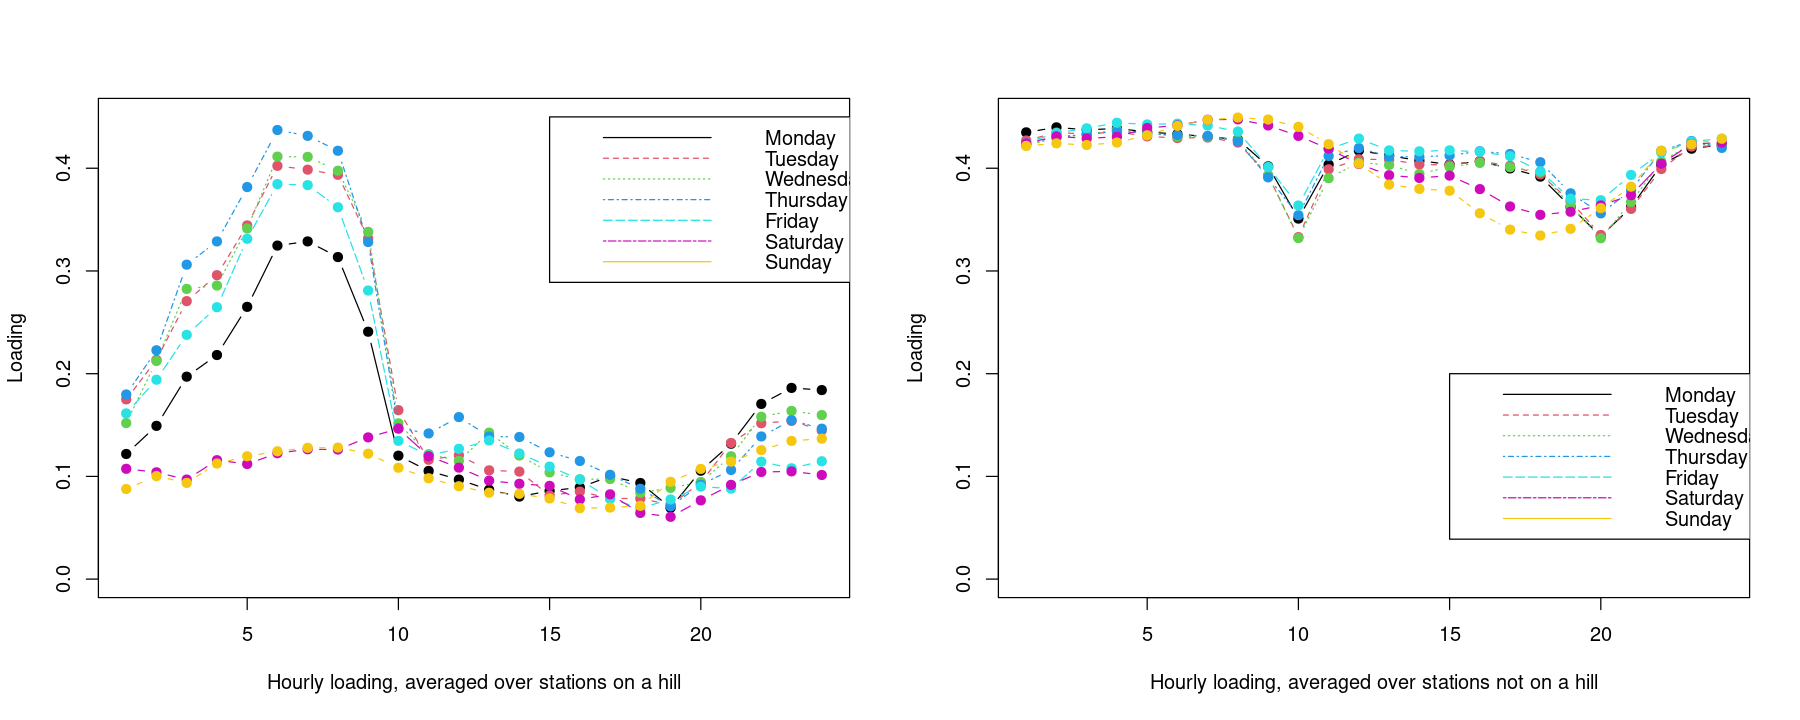

In [11]:
# Q6
xHill <- x[velib$bonus == 1, ]
xNoHill <- x[velib$bonus == 0, ]
options(repr.plot.width = 15, repr.plot.height = 6)
par(mfrow = c(1, 2))
boxplot(xHill, main = "Stations on a hill")
boxplot(xNoHill, main = "Stations not on a hill")

xHourHill <- matrix(colMeans(xHill), nrow = 24)
xHourNoHill <- matrix(colMeans(xNoHill), nrow = 24)
options(repr.plot.width = 15, repr.plot.height = 6)
par(mfrow = c(1, 2))
matplot(xHourHill, type = "b", ylim = c(0, 0.45), col = 1:7, pch = 19, 
        xlab = "Hourly loading, averaged over stations on a hill", ylab = "Loading")
legend(x = 15, y = 0.45, dayText, lty = 1:7, col = 1:7)
matplot(xHourNoHill, type = "b", ylim = c(0, 0.45), col = 1:7, pch = 19, 
        xlab = "Hourly loading, averaged over stations not on a hill", ylab = "Loading")
legend(x = 15, y = 0.2, dayText, lty = 1:7, col = 1:7)
